In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from data_processing import *
from utils import feature_desc

from sklearn.preprocessing import StandardScaler

#### Load data

In [2]:
df_og = load(csv_path = '../data/data.csv')

#### Aggregate time into clusters of size k

In [3]:
k = 15
df_og = aggregate(df_og, k)

/home/kacper/studia/cuvalley/data_processing/data_processing.py:127: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if not type(agg_df['czas']) is pd.datetime:


### Proste featury wybieram albo tworze agregując


In [4]:
df = pd.DataFrame(index=df_og.index)

In [5]:
# srednia po 'WODY POWROTNE KOLEKTORÓW [°C]'
TIR = df_og.columns[df_og.columns.str.contains('tir')].values
df['TIR'] = df_og[TIR].mean(axis='columns')

# srednia po 'TEMP POD 2 WARSTWĄ WYMURÓWKI [°C]'
TIX1 = df_og.columns[df_og.columns.str.contains('001tix')].values
df['TIX1'] = df_og[TIX1].mean(axis='columns')

# prob_s i prob_corg
PR = ['prob_s', 'prob_corg']
df[PR] = df_og[PR]

# reg nadawy koncentratu
FCX = df_og.columns[df_og.columns.str.contains('fcx')].values
df['FCX'] = df_og[FCX].mean(axis='columns')

# sumaryczna moc cieplna
NIR = df_og.columns[df_og.columns.str.contains('nir')].values
df['NIR'] = df_og[NIR]

# WENT ODCZ ZAD OBROTÓW
UXM = df_og.columns[df_og.columns.str.contains('uxm')].values
df['UXM'] = df_og[UXM].mean(axis='columns')

lagged_df = df.copy()

for i in range(60 // AGGREGATE_INTERVAL):
    lagged_df = pd.concat([lagged_df, df.shift(i+1).add_prefix(f'{i+1}th_agg_')], axis=1)

# delete rows with nans created by shifts
lagged_df = lagged_df.iloc[(60 // AGGREGATE_INTERVAL):, :]

df = lagged_df.copy()

# dodanie temperatury żużla
df["temp_zuz"] = df_og["temp_zuz"]

df = pd.concat([df, df[['temp_zuz']].shift(1).add_prefix('poprzednia_')], axis=1)

df = df.iloc[1:, :]

## Generalnie to wyrzucam outlierów

In [6]:
df = df.loc[(df_og.temp_zuz < 1319) & (df_og.temp_zuz > 1278)]

<AxesSubplot:xlabel='czas', ylabel='temp_zuz'>

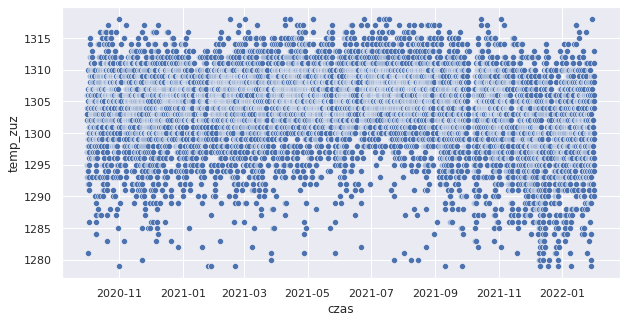

In [7]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.scatterplot(data=df, x='czas', y="temp_zuz")

## Split into train, val and test sets

In [8]:
df1, df2, df3 = split(df, proportions=(0.7, 0.15, 0.15))

## Eventually you scale the data as follows

In [9]:
df1.head(3)

TIR        TIX1  prob_s  prob_corg  \
czas                                                                  
2020-09-30 22:00:00+00:00  29.086390  418.990965    9.87        8.6   
2020-09-30 23:00:00+00:00  28.976641  418.922325    9.87        8.6   
2020-10-01 00:00:00+00:00  28.977891  418.830454    9.87        8.6   

                                 FCX        NIR        UXM  temp_zuz  
czas                                                                  
2020-09-30 22:00:00+00:00  36.478403  14.362428  92.173271    1297.0  
2020-09-30 23:00:00+00:00  36.089802  14.928113  92.183384    1295.0  
2020-10-01 00:00:00+00:00  35.183596  15.156648  92.185646    1303.0

In [10]:
dfs, mean, scale = scale(df1, df2, df3)

/home/kacper/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
df1, df2, df3 = dfs

ValueError: too many values to unpack (expected 3)

In [11]:
df1.head(3)

TIR      TIX1    prob_s  prob_corg       FCX  \
czas                                                                           
2020-09-30 22:00:00+00:00  0.348971  0.027131 -1.553764  -0.562128  0.158839   
2020-09-30 23:00:00+00:00  0.203679  0.017068 -1.553764  -0.562128  0.066925   
2020-10-01 00:00:00+00:00  0.205334  0.003599 -1.553764  -0.562128 -0.147415   

                                NIR       UXM  temp_zuz  
czas                                                     
2020-09-30 22:00:00+00:00 -1.968212 -0.313055    1297.0  
2020-09-30 23:00:00+00:00 -1.795293 -0.311378    1295.0  
2020-10-01 00:00:00+00:00 -1.725434 -0.311003    1303.0

## Data is now ready to do somthing with it

In [12]:
df1.to_csv('../data/train.csv')
df2.to_csv('../data/test.csv')
df3.to_csv('../data/val.csv')

In [13]:
df.to_csv('../data/clear.csv')